# Models

In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI


load_dotenv()


# Configure an LLM
llm = ChatOpenAI(
    model="qwen3-32b",
    temperature=0.5,
    base_url=os.environ.get("COMPATIBLE_BASE_URL"),
    api_key=os.environ.get("COMPATIBLE_API_KEY"),
    streaming=True,
    extra_body={"enable_thinking": False},
)

In [2]:
from langchain_community.embeddings import DashScopeEmbeddings


embeddings = DashScopeEmbeddings(
    model="text-embedding-v4",
    dashscope_api_key=os.environ.get("COMPATIBLE_API_KEY"),)

# Vector Store

In [3]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(host="localhost", port=6333)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="rag_from_scratch",
    embedding=embeddings,
)

retriever = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 3},
)

# Retrieval & Generation

### State

In [4]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

### Node

In [5]:
from langchain.prompts import ChatPromptTemplate

# Prompt
template = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:
"""
prompt = ChatPromptTemplate.from_template(template)

# Chain
chain = prompt | llm

In [6]:
def retrieve(state: State):
    retrieved_docs = retriever.invoke((state["question"]))
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    response = chain.invoke({"question": state["question"], "context": docs_content})
    return {"answer": response.content}

### Control Flow

In [7]:
from langgraph.graph import START, StateGraph


graph_builder = StateGraph(State)

graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)

graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve", "generate")

graph = graph_builder.compile()

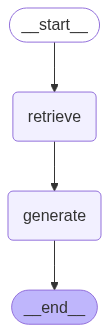

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### TEST

In [9]:
result = graph.invoke({"question": "耐克，包括匡威在美国有多少个配送中心？"})

result

{'question': '耐克，包括匡威在美国有多少个配送中心？',
 'context': [Document(metadata={'producer': 'EDGRpdf Service w/ EO.Pdf 22.0.40.0', 'creator': 'EDGAR Filing HTML Converter', 'creationdate': '2023-07-20T16:22:00-04:00', 'source': '../example_data/nke-10k-2023.pdf', 'file_path': '../example_data/nke-10k-2023.pdf', 'total_pages': 107, 'format': 'PDF 1.4', 'title': '0000320187-23-000039', 'author': 'EDGAR Online, a division of Donnelley Financial Solutions', 'subject': 'Form 10-K filed on 2023-07-20 for the period ending 2023-05-31', 'keywords': '0000320187-23-000039; ; 10-K', 'moddate': '2023-07-20T16:22:08-04:00', 'trapped': '', 'encryption': 'Standard V2 R3 128-bit RC4', 'modDate': "D:20230720162208-04'00'", 'creationDate': "D:20230720162200-04'00'", 'page': 26, 'start_index': 1074, '_id': 'ba1c21e8-4c82-4477-8fd9-6d7232cad283', '_collection_name': 'rag_from_scratch'}, page_content='In the United States, NIKE has eight significant distribution centers. Five are located in or near Memphis, Tennessee,